# **Lab 2: Naive Bayes Classification and Linear Regression**

CS 412, Introduction to Machine Learning

Department of Computer Science, University of Illinois at Chicago

***This is a group work for at most four students.***

This is your second lab work, and you will work on it with your teammates. You will learn how to apply the Naive Bayes model to filter spam SMS messages. You will also learn how to make real-valued predictions using a linear regression model. 

***Deadline:***
This assignment is due **Mar 11** (Anywhere on Earth, [AoE](https://www.timeanddate.com/time/zones/aoe)). That is, you can resubmit as often as you like provided that anywhere on Earth is still on or before this date. 

***How to submit:***
See bottom of the page

***Python version:***
The code should work on Python 3.7 or later, though it might work on earlier versions (not tested). There should be no version problem if you work on Colab.  See a more detailed introduction to Python and Colab at this [link](https://colab.research.google.com/github/cs231n/cs231n.github.io/blob/master/python-colab.ipynb#scrollTo=nxvEkGXPM3Xh).  

**Please note before starting the lab:**

1. If you use Colab, copy this file to your own Google Drive so that you can edit it.  Ignore the following message when you open the notebook (if it shows up): \\
`Unrecognized runtime "python_defaultSpec_1600651579462"; defaulting to "python3"`

2. Since the experiments involve randomness, it is important to ensure that your results are replicable. To this end, your implementation should take one integer (or any numeric value) as a seed that is used to initialize the random number generators.
See, e.g. [random.seed](https://docs.python.org/3/library/random.html).
This has been done for you in the first code block below.

3. <font color='red'> There are unit test cases provided after most functions you need to implement. Make good use of them.</font>  For numerical results (i.e., not discrete values), it is fine if your result is within 1% relative difference from the reference result.

## Problem 1. Naive Bayes Classification **(62 points)** {-}

In this problem, you will implement the Naive Bayes classification method and use it for SMS message classifcation. The SMS dataset `SMSSpamCollection` has been provided in the assignment folder, which also can be downloaded from the [UCI Link](http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).  In case the repository gets offline occasionally, we have made local copies for the [dataset](https://www.cs.uic.edu/~zhangx/teaching/SMSSpamCollection.dat) and [readme](https://www.cs.uic.edu/~zhangx/teaching/readme.txt).

To help you to better understand this algorithm, you are **not** allowed to use any off-the-shelf naive Bayes implementations from third-party libraries. We will implement it with detailed step-by-step instructions.

### Recap of the Naive Bayes Algorithm  {-}
Naive Bayes classification is a fast and simple classification method. Its efficiency stems from some simplifications we make about the underlying probability distributions, namely, the assumption about the conditional independence of features. Suppose for any class $Y$, we have a probability distribution over all possible combinations of values for a feature vector $X$:
$$
P(X|Y).
$$
The main idea of Bayesian classification is to reverse the direction of dependence --- we want to predict the label based on the features:
$$
P(Y|X).
$$
This is made possible by the Bayes theorem:
\begin{equation}
P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}. \tag{1}
\end{equation}

To make it more concrete, let us consider the SMS message classification problem. Ignoring punctuations, each SMS message contains an ordered sequence of $T$ words (case-insensitive) $X = \{X_1, ...,X_T\}$. That is, $X$ corresponds to an SMS message, and $X_i$ corresponds to the $i$-th word in it. For each message from the training set, there is a corresponding label $Y\in\{spam, ham\}$. 

**Model specification and key assumption.** The conditional distribution can be written as:
$$
P(X|Y) = P(X_1, ..., X_T|Y).
$$
Since this conditional probability is intractable, we simplify it in two steps:

1. **Assume** that all features $X_i$ are independent, conditional on the category $Y$. This leads to a naive Bayes model which writes formally as
\begin{equation}
P(X|Y) = P(X_1, ..., X_T|Y) = \prod_{i=1}^T P(X_i|Y). \tag{2}
\end{equation}

2. **Assume** that $P(X_i | Y) = P(X_j|Y)$ for all $i \neq j$.
In other words, given the label $Y$, the value of the $7$-th word has the same distribution as the value of the $10$-th word. Note this is not assumed by default in naive Bayes, and we make this additional assumption to significantly simplify our model.
It is often referred to as "tying" the probability $P(X_i|Y)$ over $i$.
As a result, the order of words no longer matters for $P(X|Y)$,
i.e., 
$$P(X=\text{'cat is cute'}|Y) \ \ = \ \ P(X=\text{'cute cat is'}|Y) \quad \text{for all } Y.
$$

Plugging Eq (2) into the Bayes theorem in Eq (1), we arrive at
$$
\begin{aligned}
P(Y|X) &= \frac{P(Y) P(X|Y)}{P(X)} = \frac{P(Y)\prod_{i=1}^T P(X_i|Y)}{P(X)} \\
&\propto P(Y)\prod_{i=1}^T P(X_i|Y),
\end{aligned}
$$
where $\propto$ denotes proportionality. Since the denominator $P(X)$ does not depend on $Y$, the prediction probability is proportional to the numerator.

**Making predictions.**
Naturally, given an SMS message $X$, we can first compute $P(Y|X)$ for all possible categories $Y$ (in this example, only two categories), and then make predictions by outputting the $Y$ that maximizes the probability. This can be expressed mathmatically as:
$$
\arg\max_Y P(Y)\prod_{i=1}^T P(X_i|Y) = \arg\max_Y \left\{\log P(Y) + \sum_{i=1}^T \log P(X_i|Y) \right\}. \tag{3}
$$
If there is a tie, we just break it arbitrarily.
Here the logarithm uses natural basis.

**Learning the model.**
To apply the prediction rule in Eq (3), we need to first figure out (formally termed "estimate") the value of $P(Y)$ and $P(X_i|Y)$ by using the training data. Recall that since we tie the conditional probabilities $P(X_i|Y)$ across all $i$,
the subscript $i$ can be dropped.
However, we still carry it just for clarity. 

Firstly, $P(Y=y)$ can be estimated by computing the frequency of category $y$ in the whole training set ($y$ can be either "$spam$" or "$ham$"). Here, in order to avoid confusion, we have used the convention that capital letters denote random variables, and lowercase letters denote their possible instantiations.

Secondly, $P(X_i = w |Y=y)$ for a word $w$ (e.g., "cat") can be estimated by counting the frequency that it appears in the training message set for a given category $y$ (derivation not required in the course):
\begin{align}
P(X_i &= w|Y=y) 
= \frac{Count(w, y)}{Count(y)}, \ \ where
\tag{4} \\
\notag
 Count(w, y) &= \text{total number of occurrence of $w$ in all SMS messages of category } y \\
\notag
Count(y) &= \text{total number of words appearing in SMS messages of category } y.
\end{align}

*Remark 1:* If $w$ appears in a single message for 3 times, then it contributes to $Count(w, y)$ by 3, not 1. Similarly, $Count(y)$ indeed equals the total length of all messages in category $y$.

*Remark 2:* Obviously, the right-hand side of Eq (4) does not depend on $i$. This is consistent with our previous note that we carry the subscript $i$ in $P(X_i|Y)$ only for clarity, while in fact different $i$ share the same $P(X_i|Y)$.

For example, suppose there are four messages 
$$
\text{{'cat is cute', ham}, {'dog rocks', spam}, {'whatever is is right', ham}, {'hello', spam}.}
$$
Then $P(X_i = '\text{is}' | \text{ham}) = 3 / 7$ (**not** $2/7$),
and $P(X_i = '\text{is}' | \text{spam}) = 0 / 3$.

Quiz (no need to submit): compute $P(X_i = w | \text{ham})$, for $w = $ 'cat', 'is', 'cute', 'whatever', and 'right'. Check if their sum is 1. Now appreciate why in Remark 1, a word appearing for mulitple times in a single message should be counted multiple times.

You may have noticed that any word $w$ with $Count(w,y)=0$ leads to $P(X_i = w|Y=y) = 0$.
As a result, by Eq (2), any message $x$ has conditional probably $P(X = x |Y=y) = 0$ if $w$ appears in $x$.
Such a "veto" is not favorable, and can create significant problems when a word in the test data has never appeared in the training data (think why?).
To bypass this issue, we can add pseudo-count, a.k.a additive smoothing:
$$
\hat{P}(X_i = w|Y=y) = \frac{Count(w, y) + \alpha}{Count(y) + N\alpha}, \tag{5}
$$
where $\alpha$ is a smoothing parameter. $\alpha=0$ corresponds to no smoothing. In our experiment, let us set $\alpha = 1.0$. $N$ denotes the number of distinct words in the vocabulary, and let us set $N = 20,000$ in this lab.

Now Let's start with data preprocessing.

In [1]:
# set up code for this experiment
import pandas as pd
import numpy as np
import string
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1)

### Data Preprocessing (not for grading) {-}

We will use `pandas` to import the dataset. Since `SMSSpamCollection` separates labels and text content in each message by a tab, we will use '\t' as the value for the `sep` argument and read raw data into a pandas dataframe. As a result, we store labels and SMS messages into two columns. To facilitate the subsequent steps, we also rename the columns by passing a list `['label', 'sms_message']` to the `names` argument of the `read_table()` method.

Let us print the first five rows of the dataframe to get a basic understanding of the dataset.

In [2]:
# Download the dataset to the server
# Import the data using the read_csv() method from pandas

import urllib.request
import shutil

url = 'https://www.cs.uic.edu/~zhangx/teaching/SMSSpamCollection.dat'
file_name = 'SMSSpamCollection.dat'
with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

df = pd.read_csv(file_name,
                    sep='\t',
                    header=None,
                    names=['label', 'sms_message'])
df.head()

,label,sms_message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Step 1: Convert string labels to numerical labels (not for grading) {-}

As we can see, there are 2 columns. The first column, which is named `label`, takes two values `spam` (the message is spam) and `ham` (the message is not spam). The second column is the text content of the SMS message that is being classified.  It is a string in which words are separated by space.

Note that the string-typed labels are unwieldy for calculating performance metrices, e.g., when calculating precision and recall scores. Hence, let's convert the lables to binary variables, 0 for `ham` and 1 for `spam`. 

In [3]:
# Run the next line only once after running the previous code block
# Running it more than once will turn the labels into NaN
df['label'] = df.label.map({'ham':0, 'spam':1})
df.head()

,label,sms_message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#### Step 2: Bag of words **(10 points)** {-}

What we have in our dataset is a large collection of text data (5,572 rows/messages). Most ML algorithms rely on numerical data to be fed into them as input, but SMS messages are usually text heavy. 

To address this issue, we would like to introduce the concept of Bag of Words (BoW), which is designed for problems with a 'bag of words' or a collection of text data. The basic idea is to count the frequency of the words in the text. It is important to note that BoW treats each word individually, ignoring the order in which the words occur. 

To count the frequency of the words in text, usually we need to process the input text data in four steps:

- Convert all strings into their lower case form
- Removing all punctuations
- Tokenization, i.e., split a sentence into individual words
- Count frequencies

Once this has been done, we are supposed to obtain a vocabulary dictionary with frequencies of each words for the given text data.

In [8]:
def count_frequency(documents):
    """
    count occurrence of each word in the document set.
    Inputs:
    - documents: list, each entity is a string type SMS message
    Outputs:
    - frequency: a dictionary. The key is the unique words, and the value is the number of occurrences of the word
    """
    """
    Here is the pseudo-code
    # Step 1: covert all strings into their lower case form
    lower_case_doc = []
    for s in documents:
        lower_case_doc.append(???)
    
    # Step 2: remove all punctuations
    no_punc_doc = []
    for s in lower_case_doc:
        no_punc_doc.append(???)
    
    # Step 3: tokenize a sentence, i.e., split a sentence into individual words 
    # using a delimiter. The delimiter specifies what character we will use to identify the beginning 
    # and the end of a word.
    words_doc = []
    for s in no_punc_doc:
        words_doc.append(???)
    
    # Step 4: count frequencies. To count the occurrence of each word in the document set. 
    # We can use the `Counter` method from the Python `collections` library for this purpose. 
    # `Counter` counts the occurrence of each item in the list and returns a dictionary with 
    # the key as the item being counted and the corresponding value being the count of that item in the list. 
    all_words = []
    for s in words_doc:
        all_words.extend(???)
    frequency = "some function/constructor on all_words"
    """

    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    lower_case_doc = []
    for doc in documents:
        lower_case_doc.append(doc.lower())
    
    no_punc_doc = []
    for doc in lower_case_doc:
        no_punc_doc.append(doc.translate(str.maketrans('', '', string.punctuation)))
        
    words_doc = []
    for doc in no_punc_doc:
        words_doc += doc.split(' ')
    
    all_words = Counter(words_doc).items()
    frequency = dict(all_words)
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return frequency

# Unit test case:
# documents = ['Hello, how are you!', 
#              'Win money, win from home.',
#              'Call me now.',
#              'Hello, Call hello you tomorrow?']
# sample outputs:
# Counter({'hello': 3, 'you': 2, 'win': 2, 'call': 2, 'how': 1, 'are': 1, 'money': 1, 'from': 1, 'home': 1,
# 'me': 1, 'now': 1, 'tomorrow': 1})
documents = ['Hello, how are you!',
            'Win money, win from home.',
            'Call me now.',
            'Hello, Call hello you tomorrow?']

freq = count_frequency(documents)
print(freq)

{'hello': 3, 'how': 1, 'are': 1, 'you': 2, 'win': 2, 'money': 1, 'from': 1, 'home': 1, 'call': 2, 'me': 1, 'now': 1, 'tomorrow': 1}


#### Step 3: Create training and test sets **(5 points)** {-}

We will partition the `SMSSpamCollection` dataset into training and test sets so that we can analyze the model's performance on data it has not witnessed during training. In Lab 1, we have implemented the `split_nfold()` method from scratch for data partition. In this Lab, we will learn to use the `scikit` library. `scikit` is a powerfull tool for machine learning and data mining, providing plenty of well-designed methods for data analysis. We'll use its `train_test_split()` method to create training and testing sets. In this experiment, we use 80% data for training and the remaining 20% data for testing. To ensure your results are replicable, you need to set the `random_state` argument of `train_test_split()` to **1**.

There is no cross validation in this Lab.

In [7]:
from sklearn.model_selection import train_test_split

# learn to read API documentation
# you can get detailed instructions about this method through this link:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
X_train, X_test, y_train, y_test = train_test_split(df['sms_message'], df['label'], test_size = 0.2, random_state=1)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

print(f'The original dataset contains {df.shape[0]} examples in total.')
print(f'The training set contains {X_train.shape[0]} examples.')
print(f'The testing set contains {X_test.shape[0]} examples.')

The original dataset contains 5572 examples in total.
The training set contains 4457 examples.
The testing set contains 1115 examples.


### Implementing Naive Bayes method from scratch {-}

#### Step 1: training the Naive Bayes Model **(16 points)** {-}

Now that we know what Naive Bayes is, we can take a closer look at how to calculate the posterior probability
$$
P(Y|X) \propto P(Y)\prod_{i=1}^T P(X_i|Y).
$$

The goal of training is to learn the prior and conditional probability from data. The calculation of the prior $P(Y=y)$ is straightforward. It can be estimated via the frequency of messages in the training set that belong to class $y$, e.g.,
$$
P(Y=spam) = \frac{\# \text{training messages in the spam category}}{\# \text{training messages}}.
$$

The conditional probability given the class label --- $P(X_i|Y)$ --- can also be estimated from the data by using Eq (5). As we assumed above, it is indeed independent of $i$ (i.e., shared by all $i$). We will leave it to you to translate Eq (5) into a concrete computation scheme. No pseudo-code is provided because by now you should be able to do it. However, do make sure that your implementation complies with the input and output data types as specified in the code.

**Hint**: 
- `count_frequency()` can be useful for computing the conditional probability.
- You need to apply the **pseudo-count** trick to handle with unseen words when computing the conditional probability for testing data.

In [72]:
def train_NB_model(X_train, y_train):
    """
    training a naive bayes model from the training data.
    Inputs:
    - X_train: an array of shape (num_train,) which stores SMS messages. each entity is a string type SMS message
    - y_train: an array of shape (num_train,). the ground true label for each training data.
    Output:
    - prior: a dictionary, whose key is the class label, and value is the prior probability.
    - conditional: a dictionary whose key is the class label y, and value is another dictionary.
                   In the latter dictionary, the key is word w, and the value is the
                   conditional probability P(X_i = w | y).
    """

    # To make your code more readable, you can implement some auxiliary functions
    # such as `prior_prob` and `conditional_prob` outside of this train_NB_model function

    # compute the prior probability
    prior = prior_prob(y_train)
    
    # compute the conditional probability
    conditional = conditional_prob(X_train, y_train)

    return prior, conditional

# Start your auxiliary functions
    
def prior_prob(y_train):
    """
    compute the prior probability
    Inputs:
    - y_train: an array that stores ground true label for training data
    Outputs:
    - prior: a dictionary. key is the class label, value is the prior probability.
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    prior = {}
    
    frequency = Counter(y_train)
    n = len(y_train)
    
    for label in frequency.keys():
        prior[label] = frequency[label] / n
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****   
    
    return prior

def conditional_prob(X_train, y_train):
    """
    compute the conditional probability for a document set
    Inputs:
    - X_train: an array of shape (num_train,) which stores SMS messages. each entity is a string type SMS message
    - y_train: an array of shape (num_train,). the ground true label for each training data.
    Ouputs:
    - cond_prob: a dictionary. key is the class label, value is a dictionary in which the key is word, the value is 
    the conditional probability of feature x_i given y.
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    alpha, N_alpha = 1, 20000
    
    spam_messages, ham_messages = [], []

    for message, label in zip(X_train, y_train):        
        if(label == 1):
            spam_messages.append(message)
        else:
             ham_messages.append(message)
    
    spam_frequency = count_frequency(spam_messages)
    ham_frequency = count_frequency(ham_messages)
    
    spam_words_count = sum(spam_frequency.values())
    ham_words_count = sum(ham_frequency.values())

    spam_cond_prob, ham_cond_prob = {}, {}
    for word in spam_frequency.keys():
        spam_cond_prob[word] = (spam_frequency[word] + alpha) / (spam_words_count + N_alpha)
    for word in ham_frequency.keys():
        ham_cond_prob[word] = (ham_frequency[word] + alpha) / (ham_words_count + N_alpha)
        
    cond_prob = {}
    cond_prob[0] = ham_cond_prob
    cond_prob[1] = spam_cond_prob
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****   
    
    return cond_prob

# unit test case:
# x_train = ['Hello, how are you!',
#           'Win money, win from home.',
#            'Call me now.',
#            'Hello, Call hello you tomorrow?']
# y_train = np.array([0,1,1,0])
#
# sample outputs:
# prior: {0: 0.5, 1: 0.5}
# conditional: {0: {'hello': 0.0001999100404817832, 'how': 9.99550202408916e-05, 
#                   'are': 9.99550202408916e-05, 'you': 0.0001499325303613374, 
#                   'call': 9.99550202408916e-05, 'tomorrow': 9.99550202408916e-05}, 
#               1: {'win': 0.00014994002399040384, 'money': 9.996001599360256e-05, 
#                   'from': 9.996001599360256e-05, 'home': 9.996001599360256e-05, 
#                   'call': 9.996001599360256e-05, 'me': 9.996001599360256e-05, 
#                   'now': 9.996001599360256e-05}}
x_train = np.array(['Hello, how are you!',
            'Win money, win from home.',
            'Call me now.',
            'Hello, Call hello you tomorrow?'])
y_train_mini = np.array([0,1,1,0])

prior = prior_prob(y_train_mini)
cond_prob = conditional_prob(x_train, y_train_mini)
print(prior)
print(cond_prob)


{0: 0.5, 1: 0.5}
{0: {'hello': 0.0001999100404817832, 'how': 9.99550202408916e-05, 'are': 9.99550202408916e-05, 'you': 0.0001499325303613374, 'call': 9.99550202408916e-05, 'tomorrow': 9.99550202408916e-05}, 1: {'win': 0.00014994002399040384, 'money': 9.996001599360256e-05, 'from': 9.996001599360256e-05, 'home': 9.996001599360256e-05, 'call': 9.996001599360256e-05, 'me': 9.996001599360256e-05, 'now': 9.996001599360256e-05}}


#### Step 2: predict label for test data **(16 points)** {-}

Once we have the two models $P(Y)$ and $P(X_i|Y)$ from *training*, we can use them to predict the label for a given test message. To this end, we need to compute the probability of all possible labels, and then predict the one with maximum probability value:
$$
\arg\max_Y P(Y)\prod_{i=1}^T P(X_i|Y). \tag{6}
$$

**Avoid numerical underflow with log-trick.**
As shown in the above equation, the calculation involves multiplying many probabilities together. Since probabilities lie in $(0,1]$, multiplying many of them together can lead to numerical underflow (i.e., a floating point number close to 0 gets rounded down to 0 by a computer), especially when $T$ is large, i.e., the test message is long.

To overcome this problem, it is common to change the calculation from the product of probabilities to the sum of log probabilities. 
That is, take the natual logarithm of the right-hand side of Eq (6) as
$$
g_Y(X) = \log P(Y) + \sum_{i=1}^T \log P(X_i|Y). \tag{7}
$$
It is much more numerically stable to compute $g_Y(X)$ and to take $\arg\max_Y g_Y(X)$ to find the most likely class label (as the output prediction). 

With $g_Y(X)$, we can easily compute the posterior probability by
$$
P(Y|X) = \frac{\exp (g_Y(X) - m)}{\sum_y \exp (g_y(X)-m)},
\text{ where  }
m = \max_y g_y(X).
$$
In our message classification problem, the summation in the denominator is just over `positive` and `negative`.
Note we subtract by $m$, which does not change the result because the numerator and denominator cancel.
However it is numerically useful because sometimes all $g_Y(X)$ are overly small and can cause numerical underflow inside exponentiation.
By subtracting $m$, $g_Y(X) - m$ will be 0 (properly scaled) for at least one value of $Y$, and be negative for the other.  And even if another $y$ still suffers underflow in exponentiating $g_y(X)-m$, the posterior probabilities will still be correct.

Again, you are expected to implement Eq (7) and loop over all test examples by yourself with no pseudo-code given.

In [73]:
from scipy.special import softmax
import math
def predict_label(X_test, prior_prob, cond_prob):
    """
    predict the class labels for the testing set
    Inputs:
    - X_test: an array of shape (num_test,) which stores test data. 
              Each entity is a string type SMS message.
    - prior_prob: a dictionary which stores the prior probability for all categories
    - cond_prob: a dictionary whose key is the class label y, and value is another dictionary.
                   In the latter dictionary, the key is word w, and the value is the
                   conditional probability P(X_i = w | y).
    Outputs:
    - predict: an array that stores predicted labels
    - test_prob: an array of shape (num_test, num_classes) which stores the posterior probability of each class
    """

    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    predict, test_prob = [], []
    pred_labels = prior_prob.keys()

    for doc in X_test:
        word_count = count_frequency([doc])
        posterior = [0 for _ in pred_labels]
        
        for i, label in enumerate(pred_labels):            
            posterior[i] += compute_test_prob(word_count, prior_prob[label], cond_prob[label])
            
        max_val = max(posterior)
        predict.append(posterior.index(max_val))
        test_prob.append(list(softmax([val-max_val for val in posterior])))

##     Alternate Approach:
#
#     for doc in X_test:
#         frequency = count_frequency([doc])
#         posterior = [math.log(prior_prob[label]) for label in pred_labels]
#         for word in frequency:
#             for i, label in enumerate(pred_labels):
#                 posterior[i] += math.log(cond_prob[label].get(word, (alpha/N_aplha)))
        
#         max_val = max(posterior)
#         predict.append(posterior.index(max_val))
#         test_prob.append(list(softmax([val-max_val for val in posterior])))
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return predict, test_prob

def compute_test_prob(word_count, prior_cat, cond_cat):
    """
    predict the class label for one test example
    Inputs:
    - word_count: a dictionary which stores the frequencies of each word in a SMS message. 
                  Key is the word, value is the number of its occurrence in that message
    - prior_cat: a scalar. prior probability of a specific category
    - cond_cat: a dictionary. conditional probability of a specific category
    Outputs:
    - prob: posterior probability of a specific category for the test example
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    alpha, N_alpha = 1, 20000
    prob = math.log(prior_cat)
    
    for key, value in word_count.items():
        prob += value * math.log(cond_cat.get(key, (alpha/N_alpha)))
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return prob

# unit test case:
# x_test = np.array(['Hello, how are you!'])
# sample outputs:
# y_pred: [0] 
# prob: [[0.92298104 0.07701896]]
x_test = np.array(['Hi, how are you today!'])
y_pred, test_prob = predict_label(x_test, prior, cond_prob)
print(y_pred, test_prob)

[0] [[0.9229810319086033, 0.07701896809139684]]


#### Step 3: compute performance metrics **(5 points)** {-}
You may have noticed that the classes are heavily imbalanced. There are only 747 `spam` messages, compared with 4827 `ham` messages. If a classifier simply predicts all messages as `ham`, it will get around 86% accuracy (pretty high). Therefore, accuracy is not a good metric in this case for evaluating the performance of the classifier. As we did before, we can use F-score metrics. But this time we will not implement it from the scratch. Instead, we will learn how to use the builtin methods from `scikit`. [Here](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) is a summary of well-implemented and commonly used metrics for evaluating the quality of a model's predictions. 

In this task, you need to **report** the testing accuracy, confusion matrix, and F1 score of the Naive Bayes method by choosing proper functions from `scikit` to compute those metrics with required arguments.

Hint: you need to import methods from `sklearn.metrics` before using them.

In [74]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def compute_metrics(y_pred, y_true):
    """
    compute the performance metrics
    Inputs:
    - y_pred: an array of predictions
    - y_true: an array of ground true labels
    Outputs:
    - acc: accuracy
    - cm: confusion matrix
    - f1: f1_score
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return acc, cm, f1

# unit test case:
# y_pred = np.array([0,1,1,1,0,1])
# y_true = np.array([0,1,0,0,1,1])
# 
# sample outputs:
# acc: 0.5 
# cm: [[1 2]
#      [1 2]] 
# f1: 0.5714285714285715
y_pred = np.array([0,1,1,1,0,1])
y_true = np.array([0,1,0,0,1,1])
acc, cm, f1 = compute_metrics(y_pred, y_true)
print(acc, cm, f1)

0.5 [[1 2]
 [1 2]] 0.5714285714285715


#### Step 4: Plot ROC curve and print other results **(10 points)** {-}

ROC (Receiver Operating Characteristics) curve is one of the most commonly used metrics for evaluating the performance of machine learning algorithms, especially when the classes are imbalanced.

ROC is a probability curve for different classes. ROC tells us how good the model is for distinguishing the given classes, in term of the **predicted probability** (not the final hard label in pos/neg). A typical ROC curve has False Positive Rate (FPR) on the $x$-axis and True Positive Rate (TPR) on the $y$-axis. To obtain the FPR and TPR, you can use the `roc_curve` method from `scikit`. This `roc_curve` function takes two arguments: 1) the ground truth labels of the test examples, and 2) the predicted probability that each example is positive. It returns the FPR and TPR which can be used for plotting.

You can even compute the area under the curve (AUC) by calling `roc_auc_score` which takes the same arguments as `roc_curve` required.

In this task, **plot** the ROC curve and compute the AUC score.

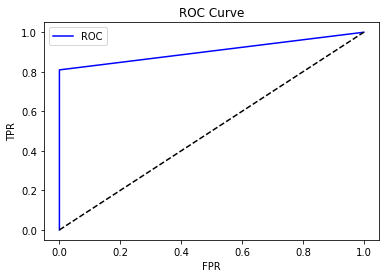

0.9047619047619048 0.9748878923766816 0.8947368421052632 [[968   0]
 [ 28 119]]


In [79]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(fpr, tpr):
  plt.plot(fpr, tpr, color='blue', label='ROC')
  plt.plot([0, 1], [0, 1], color='black', linestyle='--')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title('ROC Curve')
  plt.legend()
  plt.show()

# We now compute the test performance.
# X_train, X_test, y_train, y_test are the same as above

# training naive Bayes model 
prior, cond = train_NB_model(X_train, y_train)

# evaluate on test set
y_pred, prob = predict_label(X_test, prior, cond)

# Implement the following:
#   1. compute the fpr and tpr for roc curve using the probability of being positive
#   2. compute the auc score
#   3. plot roc curve by calling the plot_roc_curve() method
#   4. print AUC score, test accuracy, F-score, and Confusion matrix

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****    
fpr, tpr, thres = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plot_roc_curve(fpr, tpr)
acc, cm, f1 = compute_metrics(y_pred, y_test)
print(auc, acc, f1, cm)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Problem 2: Linear regression **(38 points)** {-}

In this section, we will explore linear regression model. The dataset we will use for this section is Wine Qualuty, whose description can be found [here](http://archive.ics.uci.edu/ml/datasets/Wine+Quality). This dataset contains **4898** examples, each containing **11** features (the first 11 columns), and the **last** (12-th) column is the value we want to predict. The dataset can be downloaded here [`winequality-white.csv`](https://www.cs.uic.edu/~zhangx/teaching/winequality-white.csv) (our code will download it directly). 

Different from classification models, a regression model is used to predict real values rather than the category an example belongs to. Linear regression is a linear approach to modeling the relationship between features and real value target. To perform supervised learning, we represent the hypothesis as a linear function of features ($x$) to predict the output ($y$).

\begin{equation}
f(x) = \theta_0 + \theta_1x_1 + ... + \theta_nx_n    \tag{8}
\end{equation}

Here $\theta_i$'s are the **parameters** parameterizing the space of linear functions mapping from $\mathcal{X}$ to $\mathcal{Y}$. Our goal is to **learn** these parameters so that we can find a linear function in this hypothesis space to estimate the output $y$.

To simplify the notation and ease the computation, we **pad** the input $x$ by letting $x_0=1$. That is, for an example with three features $x=[x_1, x_2, x_3]$, the padded feature vector will be $x=[1,x_1, x_2, x_3]$. Then, the linear function can be written as:

\begin{equation}
f_\theta(x) = \sum_{j=0}^n \theta_j x_j = \theta^\top x    \tag{9}
\end{equation}
where on the right-hand side above we are viewing $\theta$ and $x$ both as vectors, and here $n = 11$ is the number of features. 

Given a training set, the way to learn these parameters is to make $f_\theta(x)$ close to $y$. To measure the closeness, we use Mean-Squared-Error (MSE) here. The loss function can therefore be defined as:

\begin{equation}
L(\theta) = \frac{1}{2m}\sum_{i=1}^m(f_\theta(x^{(i)})-y^{(i)})^2 = \frac{1}{2m}\sum_{i=1}^m(\theta^\top x^{(i)}-y^{(i)})^2,  \tag{10}
\end{equation}
where the superscript $(i)$ denotes the $i$-th example, 
and $m$ is the total number of training samples. To learn the parameter $\theta$, our goal is to **minimize** the above loss function. In this lab, we will explore two different methods to learn the parameter: 

1. Gradient descent
2. Closed-form solution (root of the gradient)

## 2.1 Data preprocessing {-}

Once we have received the dataset, we first need to preprocess it.  Very often, the features in a dataset are of very different scale, which can slow down the optimization for Eq (10). To accelerate it, we need to normalize each feature by substracting its mean value, and then dividing by its standard deviation (std). Assuming $X_i = [x_i^{(1)}, ... , x_i^{(m)}]$ is the $i$-th feature in the training set (across the $m$ examples), the normalized feature $i$ for the $j$-th training example can be computed by:
\begin{equation}
\hat{x}^j_i = \frac{x^j_i - m_i}{s_i},
\text{ where } m_i = mean(X_i), \text{ and } s_i = std(X_i).
  \tag{11}
\end{equation}

**Step 1: normalize the training set (3 points)** {-}

In the following code block, implement a function `featureNormalization`. The input is the training set. The output is the normalized training set, along with the mean and std of each features. You will need the mean and std to apply to the test set later.

In [88]:
import numpy as np
import matplotlib.pyplot as plt
def featureNormalization(X):
    """
    Normalize each feature for the input set
    Input:
    - X: a 2-D numpy array of shape (num_train, num_features)
    Outputs:
    - X_normalized: a 2-D numpy array of shape (num_train, num_features)
    - X_mean: a 1-D numpy array of length (num_features)
    - X_std: a 1-D numpy array of length (num_features)
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_normalized = (X-X_mean)/X_std
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return X_normalized, X_mean, X_std

"""
 Unit test case
 Should print
[[ 0.49109521 -0.40242644 -0.92156595 -0.1052653 ]
 [ 0.90298151  1.37532553  1.3897809   1.27398003]
 [-1.39407672 -0.97289909 -0.46821496 -1.16871473]]
[0.99 3.12 4.47 4.51]
[0.63124216 2.26128282 1.34553583 3.70492465]
"""
X = np.array([[1.30,2.21,3.23,4.12], [1.56, 6.23, 6.34, 9.23], [0.11, 0.92, 3.84, 0.18]])
X_normalized, X_mean, X_std = featureNormalization(X)
print(X_normalized)
print(X_mean)
print(X_std)

[[ 0.49109521 -0.40242644 -0.92156595 -0.1052653 ]
 [ 0.90298151  1.37532553  1.3897809   1.27398003]
 [-1.39407672 -0.97289909 -0.46821496 -1.16871473]]
[0.99 3.12 4.47 4.51]
[0.63124216 2.26128282 1.34553583 3.70492465]


**Step 2: normalize the test set (3 points)** {-}

The above normalization function will be used for the training set. At test time, we will need to normalize the test data in the same way. However, we shouldn't compute new mean and std from the test set itself, because it may be inconsistent with the training data.  Instead, we will apply the mean $m_i$ and std $s_i$ computed from the training set.  Given a text example $[x_1, \ldots, x_m]$, we just transform $x_i$ into $(x_i - m_i)/s_i$,
where $m_i$ and $s_i$ are computed from the training data as in the *where* clause of Eq (11).

In the following code block, implement a function `applyNormalization`, which normalizes the test set for each feature using the provided mean and std.

In [90]:
def applyNormalization(X, X_mean, X_std):
    """
    Normalize each feature for the input set X
    Input:
    - X: a 2-D numpy array of shape (num_test, num_features)
    - X_mean: a 1-D numpy array of length (num_features)
    - X_std: a 1-D numpy array of length (num_features)

    Output:
    - X_normalized: a 2-D numpy array of shape (num_test, num_features)  
    """

    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    X_normalized = (X-X_mean)/X_std
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return X_normalized

"""
Unit test case
Should print
[[ 3.00e-01  1.21e+00  6.15e-01  4.02e+01]
 [ 5.60e-01  5.23e+00  2.17e+00  9.13e+01]
 [-8.90e-01 -8.00e-02  9.20e-01  8.00e-01]]
"""
X =  np.array([[1.30,2.21,3.23,4.12], [1.56, 6.23, 6.34, 9.23], [0.11, 0.92, 3.84, 0.18]])
X_mean = np.array([1.0, 1.0, 2.0, 0.1])
X_std = np.array([1.0, 1.0, 2.0, 0.1])
X_normalized = applyNormalization(X, X_mean, X_std)
print(X_normalized)

[[ 3.00e-01  1.21e+00  6.15e-01  4.02e+01]
 [ 5.60e-01  5.23e+00  2.17e+00  9.13e+01]
 [-8.90e-01 -8.00e-02  9.20e-01  8.00e-01]]


## 2.2 Gradient Descent {-}

In this section, you will need to implement the gradient descent algorithm that trains the linear regression model. Some introductions to gradient descent can be found [here](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html).

**Step 1: implement the loss function (3 points)** {-} 

As introduced at the begining of this problem, we will use MSE to measure the loss. In the following code block, implement a function `computeMSE`. Follow Equation (10), and the function should compute the MSE for the input set with the given $\theta$.

In [124]:
def computeMSE(X, y, theta):
    """
    Compute MSE for the input set (X,y) with theta
    Inputs:
    - X: a 2-D numpy array of shape (num_samples, num_features+1)
    - y: a 1-D numpy array of length (num_samples)
    - theta: a 1-D numpy array of length (num_features+1)
    Output:
    - error: MSE, a real number
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    y_pred = np.sum(theta.T*X, axis=1)
    error = np.sum(np.square(y_pred-y), keepdims=True) / (2*len(y))
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return error[0]

# Unit test case:
# Should print 73.0
X = np.array([[2.0, 1.0, 3.0], [3.0, 6.0, 2.0]])
y =  np.array([1.0, 1.0])
theta = np.array([[1.0], [2.0],[1.0]])
error = computeMSE(X, y, theta)
print(error)

73.0


**Step 2: compute the gradient of the loss function (7 points)** {-} 

Recall that our goal is to find the parameter $\theta$ that can minimize the loss $L(\theta)$. To find the $\theta$ with gradient descent method, we start from some initial $\theta$, and then repeatedly perform the update:
\begin{equation}
\theta = \theta - \alpha\nabla_{\theta}L(\theta).    \tag{12}
\end{equation}

Here $\alpha > 0$ is a step size, a.k.a., learning rate.
To enable this update rule, we first need to compute the gardient in $\theta$. 

1. Please derive the gradient of $\theta$ from Eq (10), and type the result in the following line:

$$
\nabla_{\theta}L(\theta) = \frac{1}{m}\sum_{i=1}^m(\theta^\top x^{(i)}-y^{(i)}) x^{(i)}, 
$$

Note for computational efficiency, your expression is not allowed to have $\sum_{i=1}^m$, and cannot have any multiplication of two matrices.  Multiplications of a matrix and a vector is allowed. Here is a hint.  Let $a_i$ and $b_i$ be vectors.  Then
$$
  \sum_i (\theta^\top b_i) a_i = \sum_i a_i (b_i^\top \theta) = \left(\sum_i a_i b_i^\top \right) \theta = (A B^\top) \theta = A (B^\top \theta),
$$
where $A = [a_1, ..., a_m]$ and $B = [b_1, ..., b_m]$.

2. Then, implement a function `computeGradient` to compute the gradient $\nabla_{\theta}L(\theta)$ by following the expression you just derived above.

In [163]:
def computeGradient(X, y, theta):
    """
    Compute the gradient of theta
    Inputs:
    - X: A 2-D numpy array of shape (num_train, num_features+1)
    - y: A 1-D numpy array of length (num_train)
    - theta: A 1-D numpy array of length (num_features+1)
    Output:
    - gradient: A 1-D numpy array of length (num_features+1)
    """

    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    y_pred = np.sum(theta.T*X, axis=1)
    gradient = np.sum((y_pred - y)*X.T, axis=1, keepdims=True) / len(y)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return gradient

"""
# Unit test case:
# Should return
[[30.]
 [51.]
 [25.]]
""" 
X = np.array([[2.0, 1.0, 3.0], [3.0, 6.0, 2.0]])
y =  np.array([1.0, 1.0])
theta = np.array([[1.0], [2.0],[1.0]])
gradient = computeGradient(X, y, theta)
print(gradient)


[[30.]
 [51.]
 [25.]]


**Step 3: implement the gradient descent algorithm (4 points)** {-} 

Now we can use the update rule in Equation (12) to find the $\theta$ that minimizes $L(\theta)$. We start from some initial $\theta_0$, then repeatedly take a step in the direction of steepest decrease of $L$. The $\alpha$ in Equation (12) indicates how large the step we want to take at every update. We repeat the updates for a certain number of iterations, and the last updated $\theta$ will be the $\theta$ we find.
In the following code block, implement a function `gradientDescent`, which updates $\theta$ for `num_iters` times and records the loss value (MSE) at every iteration.

In [169]:
def gradientDescent(X, y, theta, alpha, num_iters):
    """
    Update theta using equation (5) for num_iters times.
    Input: 
    - X: a numpy array of shape (num_train, num_features+1)
    - y: a numpy array of shape (num_train, 1)
    - theta: a 1-D numpy array of length (num_features+1)
    - alpha: learning rate, a scalar
    - num_iters: an integer specifying how many steps to run the gradient descent
    Outputs:
    - theta: the final theta, a 1-D numpy array of length (num_features+1). 
           You can directly overwrite the theta in the input argument, and return it.
    - Loss_record: a 1-D numpy array of length (num_iters), 
          recording the loss value of Eq (10) at every iteration, 
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    Loss_record = np.zeros(num_iters)
    for i in range(num_iters):
        Loss_record[i] = computeMSE(X, y, theta)
        theta -= alpha * computeGradient(X, y, theta)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return theta, Loss_record

"""
# Unit test case:
# Should return
[[0.3322825]
 [0.858839 ]
 [0.446925 ]]
[37.5778     19.36559064 10.00046345]
"""
X = np.array([[2.0, 1.0, 3.0], [3.0, 6.0, 2.0]])
y =  np.array([1.0, 1.0])
theta = np.array([[1.0], [2.0],[1.0]])
alpha = 0.01
num_iters = 3
theta, Loss_record = gradientDescent(X, y, theta, alpha, num_iters)
print(theta)
print(Loss_record)

[[0.3322825]
 [0.858839 ]
 [0.446925 ]]
[73.         37.5778     19.36559064]


## 2.3 Train the linear regression model with gradient descent {-}

Now we are ready to chain all the above functions together to perform the linear regression training on the Wine Quality dataset. 

**Step 1: load the data (not for grading)**

In [170]:
# First load the data (this code block is not for grading)

import urllib.request
import shutil

url = 'https://www.cs.uic.edu/~zhangx/teaching/winequality-white.csv'
file_name = 'winequality-white.csv'
with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

data = np.genfromtxt(file_name, delimiter=";", skip_header=1)
print(data.shape)

(4898, 12)


**Step 2: training and testing (7 points)**

After loading the dataset, split the dataset into training and test sets. Please split the first **4000** samples as training set and the rest as test set. Then perform the following:

*   Normalize training set features
*   Pad the normalized training features by a constant 1, as the new first feature
*   Initialize $\theta$ as a zero vector
*   Update $\theta$ using gradient descent (`num_iters` and `alpha` are provided)
*   **Plot** a figure where $x$-axis is the number of iterations, $y$-axis is the loss value (MSE).
*   Apply normalization to test set features, pad the features
*   Compute the test error (MSE) and **print** out the test error

0.2989660330832716


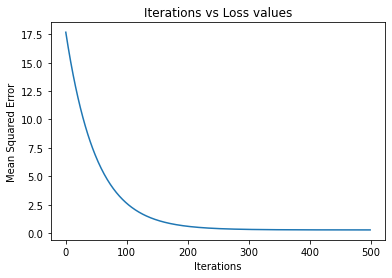

In [230]:

num_train = 4000
alpha = 0.01
num_iters = 500

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
def pad_ones(X):
    return np.hstack(( np.ones((X.shape[0], 1)), X))
    
train_X, test_X, train_y, test_y = train_test_split(data[:,:-1], data[:,-1])
train_count, features_count = train_X.shape

train_X, mean_X, std_X = featureNormalization(train_X)
train_X = pad_ones(train_X)

theta = np.zeros((features_count + 1, 1))
theta, Loss_record = gradientDescent(train_X, train_y, theta, alpha, num_iters)

plt.plot(range(num_iters), Loss_record)
plt.title('Iterations vs Loss values')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')

test_X = applyNormalization(test_X, mean_X, std_X)
test_X = pad_ones(test_X)

error = computeMSE(test_X, test_y, theta)
print(error)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

## 2.4 Effect of different learning rate (4 points) {-}

To investigate the effect of learning rate, repeat the learning process (gradient descent) with different learning rate in $[1.0, 0.1, 0.01, 0.001]$. 
**Plot** 4 figures corresponding to different learning rates, where the $x$-axis is the number of iterations, 
and the $y$-axis is the loss value (MSE). **Print** the test error (MSE) respectively in the format "test MSE for using learning rate __ is __" (four lines in total).

C:\Users\laksh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-124-91faaf22baef>:13: RuntimeWarning: overflow encountered in square
  error = np.sum(np.square(y_pred-y), keepdims=True) / (2*len(y))


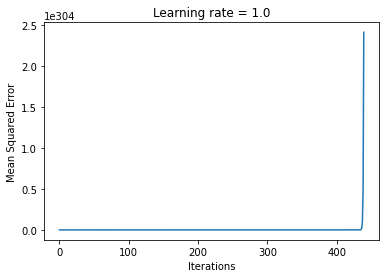

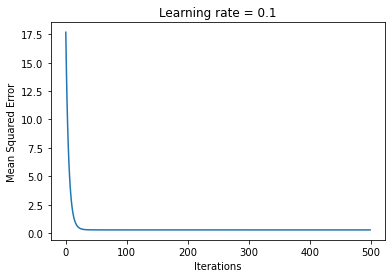

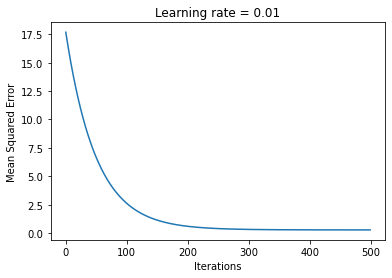

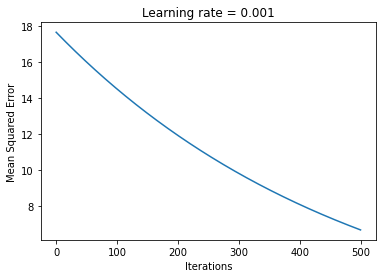

In [236]:
learning_rates = [1.0, 0.1, 0.01, 0.001]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for alpha in learning_rates:
    theta = np.zeros((features_count + 1, 1))
    theta, Loss_record = gradientDescent(train_X, train_y, theta, alpha, num_iters)
    plt.plot(range(num_iters), Loss_record)
    plt.title('Learning rate = {}'.format(alpha))
    plt.xlabel('Iterations')
    plt.ylabel('Mean Squared Error')
    plt.show()
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

## 2.5 Closed-form solution  {-}

Gradient descent minimizes $L$ by updating $\theta$ iteratively. There is another way to find the $\theta$ explicitly. Indeed, by finding the root of the gradient $\nabla_\theta L(\theta)$ (i.e., the $\theta$ such that $\nabla_\theta L(\theta) = 0$), we can obtain a closed-form solution of $\theta$ that minimizes the loss $L$.

**Step 1: find the root of the gradient to obtain the closed-form solution of $\theta$  (5 points)**

Type your result in the following lines:

$$
\nabla_{\theta}L(\theta) = 0 \quad \Rightarrow \quad 
\theta = 
$$
Then, implement a function `closeForm` to compute the closed-form solution of $\theta$ using the expression you have derived above. 

In [237]:
def closeForm(X, y):
    """
    Compute close form solution for theta
    Inputs:
    - X: a numpy array of shape (num_train, num_features+1)
    - y: a 1-D numpy array of length (num_train)
    Output:
    - theta: a 1-D numpy array of length (num_features+1)
    """
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    y = y.reshape(-1, 1)
    theta = np.dot(np.linalg.inv(X.T@X), X.T@y)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return theta

"""
# Unit test case:
# Should return
[[ 0.76470588]
 [-0.17647059]
 [-0.11764706]]
"""
X = np.array([[2.0, 1.0, 3.0], [3.0, 6.0, 2.0], [-1, 0, 2.0]])
y = np.array([1.0, 1.0, -1.0])
theta = closeForm(X, y)
print(theta)

[[ 0.76470588]
 [-0.17647059]
 [-0.11764706]]


**Step 2: evaluate the test error using closed-form solution (2 points)** {-} 

Compute a new $\theta$ using the closed-form solution. Evaluate the new $\theta$ on test set by **printing** the test error (MSE) in the format: "test MSE using close form solution is : __".

In [238]:
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
theta = closeForm(train_X, train_y)
test_error = computeMSE(train_X, train_y, theta)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

print('test MSE using close form solution is : ', test_error)


test MSE using close form solution is :  0.2774079006759937


# Submission Instruction {-}

You're almost done! Take the following steps to finally submit your work.

1. After executing all commands and completing this notebook, save your `Lab_2.ipynb` as a PDF file, named as `X_Y_UIN.pdf`, where `X` is your first name, `Y` is your last name, and `UIN` is your UIN. Make sure that your PDF file includes all parts of your solution, including the plots. 

> * Print out all unit test case results before printing the notebook into a PDF.
* If you use Colab, open this notebook in Chrome.  Then File -> Print -> set Destination to "Save as PDF".  If the web page freezes when printing, close Chrome and reopen the page. If Chrome doesn't work, try Firefox.
* If you are working on your own computer, we recommend using the browser (not jupyter) for saving the PDF. For Chrome on a Mac, this is under *File->Print...->Open PDF in Preview*. When the PDF opens in Preview, you can use *Save...* to save it.
* Sometimes, a figure that appears near the end of a page can get cut.  In this case, try to add some new lines in the preceding code block so that the figure is pushed to the beginning of the next page.

2. Upload `X_Y_UIN.pdf` to Gradescope under `Lab_2_Written`.

3. A template of `Lab_2.py` has been provided.  For all functions in `Lab_2.py`, copy the corresponding code snippets you have written into it.  Do not copy any code of plotting figures. **Do not** change the function names.  **Do not** import libraries in Lab_2.py. 

4. Zip `Lab_2.py` and `Lab_2.ipynb` (**2 files**) into a zip file named `X_Y_UIN.zip`. Suppose the two files are in the folder `Lab_2`.  Then zip up the two files inside the `Lab_2` folder.  Do NOT zip up the folder `Lab_2`. Submit this zip file to Gradescope under `Lab_2_Code`. 

5. The autograder on Gradscope will be open all the time. We designed some simple test cases to help you check wehther your functions is execuable. You will see the results of running autogrder once you submit your code. Please follow the error messages to debug. If you see 'test `function_name` completed', it means your function is execuable; otherwise please follow the error messages to debug. Since those simple test cases are designed for debugging, it does not guaranttee your solution will work well on the real dataset. It is your responsibility to make your code logically correct. Since all functions are tested in batch, the autograder might take a few minutes to run after submission.

6. Only one member of each team needs to submit.  But please specify **all** your teammates on Gradescope. After each submission, please click 'Add Group Member' (right up corner of your submission page) to claim all teammates.

You can submit to Gradescope as many times as you would like. We will only consider your last submission.